# Introduction

The Makridakis Competitions (also known as the M-Competitions) are a series of open competitions organized by teams led by forecasting researcher Spyros Makridakis and intended to evaluate and compare the accuracy of different forecasting methods - source(Wikipedia)

Attempting to to approach the forecasting with a number of models. Used Tarun's Kernel to begin with.
And it will be evolved over with my own intuitions etc. We have been challenged to forecast the data 28 days in to the future ie from day 1914 to day 1941. We would be attempting to due the forecast as well as the uncertainty distribution.

### The DataSet

* calendar.csv - Contains the dates on which products are sold. The dates are in a yyyy/dd/mm format.

* sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913].

* submission.csv - Demonstrates the correct format for submission to the competition.

* sell_prices.csv - Contains information about the price of the products sold per store and date.

* sales_train_evaluation.csv - Available one month before the competition deadline. It will include sales for [d_1 - d_1941].



Lets try to visualize the data and get some insights

Import Libraries

In [1]:
import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad
from statsmodels.tsa.seasonal import seasonal_decompose

import scipy
from scipy.fftpack import fft
import statsmodels
from scipy import signal
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from fbprophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import warnings
warnings.filterwarnings("ignore")


In [2]:
input_dir = '/kaggle/input/m5-forecasting-accuracy'
calender = pd.read_csv('%s/calendar.csv' % input_dir)
selling_prices = pd.read_csv('%s/sell_prices.csv' % input_dir)
sample_submission = pd.read_csv('%s/sample_submission.csv' % input_dir)
sales_train_val = pd.read_csv('%s/sales_train_validation.csv' % input_dir)

In [3]:
sales_train_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


We can observe there is an id for each of departments, category, item and a general id which is a combination of all these. Many of the data points ahs got zero values. The sales date are denoted by 'd_'.

## Data Visualization

In [4]:
ids = np.unique(sales_train_val.id.values)
date_cols = [c for c in sales_train_val.columns if 'd_' in c]

## Understanding the sales data


By plotting the sales data for a shorter time duration, we can get a better picture or better visualization


In [5]:
x_1 = sales_train_val.loc[sales_train_val['id'] == ids[12]].set_index('id')[date_cols].values[0][:120]
x_2 = sales_train_val.loc[sales_train_val['id'] == ids[4]].set_index('id')[date_cols].values[0][240:360]
x_3 = sales_train_val.loc[sales_train_val['id'] == ids[47]].set_index('id')[date_cols].values[0][600:720]

fig = make_subplots(rows=3, cols=1)
fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=False,
                    mode='lines+markers', name="First sample", marker=dict(color="limegreen")), row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=False,
                    mode='lines+markers', name="Second sample", marker=dict(color="hotpink")), row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=False,
                    mode='lines+markers', name="Third sample", marker=dict(color="lightsteelblue")), row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample Sales Snippets")
fig.show()

As we can see that the since the data changes sharply between the days.  We can apply some smoothening to visualize any underlying trends. At firt lets start with some time averaging using **Savitzky golay** filters. 
By controlling the window length and polynomila order we we can get a smoothened curve from these. The window length chosen here just bu intuition, if its bigger you will get a more smoothened curve.

Also another way  we can go for is wavelet denoising

In [6]:
x_1 = sales_train_val.loc[sales_train_val['id'] == ids[5]].set_index('id')[date_cols].values[0][:120]
x_2 = sales_train_val.loc[sales_train_val['id'] == ids[7]].set_index('id')[date_cols].values[0][240:360]
x_3 = sales_train_val.loc[sales_train_val['id'] == ids[13]].set_index('id')[date_cols].values[0][600:720]

smoothened_signal_1 = signal.savgol_filter(x_1, polyorder = 3, window_length=15)
smoothened_signal_2 = signal.savgol_filter(x_2, polyorder = 3, window_length=15)
smoothened_signal_3 = signal.savgol_filter(x_3, polyorder = 3, window_length=15)


fig = make_subplots(rows=3, cols=1)
fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=False,
                    mode='lines+markers', name="original signal", marker=dict(color="limegreen")), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=smoothened_signal_1, showlegend=False,
                    mode='lines', name="smoothened signal", marker=dict(color="darkgreen")), row=1, col=1)



fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=False,
                    mode='lines+markers', name="original signal", marker=dict(color="hotpink")), row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=smoothened_signal_2, showlegend=False,
                    mode='lines', name="smoothened signal", marker=dict(color="darkred")), row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=False,
                    mode='lines+markers', name="original signal", marker=dict(color="lightsteelblue")), row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=smoothened_signal_3, showlegend=False,
                    mode='lines', name="smoothened signal", marker=dict(color="darkslateblue")), row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample Sales Snippets")
fig.show()


### Aggregate Sales vs Time

We can start doing the same for different aggregation levels. Since we haver got three states, That can be an aggregation parameter, then storewise, department wise etc.

In [7]:
aggr_array = []
for d in date_cols:
    aggr_array.append(sales_train_val[d].values.sum())
    
date_range = calender['date']
d_st = date_range.values[0]
d_end = date_range.values[1912]
    
date_range = pd.date_range(start=d_st, end=d_end)

# Doing a monthly time averaging we can plot them along side

daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)
monthly_time_seies_df = daily_time_series_df.resample('1M').sum()

fig = make_subplots(rows=2, cols=1, subplot_titles=("Daily Aggregate Sales", "Monthly Aggregate Sales"))

fig.add_trace(go.Scatter(x=date_range, y=aggr_array, showlegend=False,
                    mode='lines', name="Aggregate Sales", marker=dict(color="darkgreen")), row = 1, col=1)
fig.add_trace(go.Scatter(x=monthly_time_seies_df.index[1:-1], y=monthly_time_seies_df['Sales'].values[1:-1],
                         marker=dict(color="darkgreen")), row = 2, col=1)

fig.update_layout(title="Aggregate Sales",height=1200, width=1000)
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Sales in Units", row=1, col=1)
fig.update_yaxes(title_text="Sales in Units", row=2, col=1)
fig.show()

Ahh nice! plotly is a savior!. Good thing is that you can zoom in over the graphs.

some observations we can take away
*  Sales are increasing over time
*  There are seasonal behaviors in sales trends such as monthly/weekly trends. Out of this, the weekly trends are very evident.
* End of every year there is a sharp dip in sales may be due to the vacation/holiday season.

May be we can do some time based normalisation and apply a Fourier/Wavelet transform to get more idea about the trend frequencies. But lets keep it for later(sorry, just being a fan of Fourier transforms !)

Now lets plot the sepearte data statewise

In [8]:
store_ids = sales_train_val['store_id'].values
state_id = []

for id in store_ids:
    state_id.append(id[:2])
state_id = np.array(state_id)
sales_train_val['state_id'] = state_id

df_grouped_statewise = sales_train_val.groupby('state_id')

fig = go.Figure()

for name, group in df_grouped_statewise:
    aggr_array = []
    for d in date_cols:
        aggr_array.append(group[d].values.sum())
    daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)
    monthly_time_seies_df = daily_time_series_df.resample('1M').sum()
    fig.add_trace(go.Scatter(x=monthly_time_seies_df.index[1:-1], y=monthly_time_seies_df['Sales'].values[1:-1],
                             showlegend=True, mode='lines', name="%s Sales" % name))
fig.update_layout(
    title="State Wise Aggregate Sales", xaxis_title="Date", yaxis_title="Unit Sales", height=600, width=1000)
fig.show()

## Plotting Aggregate Sales per Stores

There are 3 categories and 10 stores in total. We can try plotting for each of the categories and for stores in each state. Using matplotlib this time. Here I am using both plotly and Matplotlib throughout the notebook. Users can have a good feel how these libraries can be used for dynamoic plotting of data.


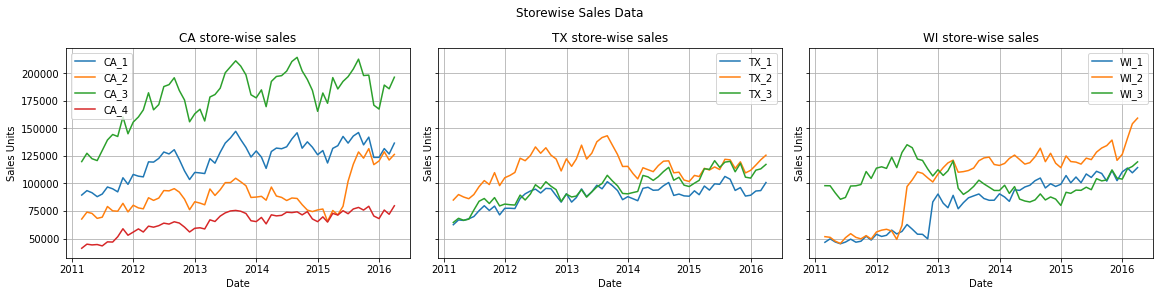

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4), sharey=True, constrained_layout=True)
fig.suptitle('Storewise Sales Data')
i = 0
for state_name, state_group in df_grouped_statewise:
    df_store_wise_grouped = state_group.groupby('store_id')
    axs[i].set_title('%s store-wise sales' % state_name)
    axs[i].set(xlabel='Date', ylabel='Sales Units')
    axs[i].grid(True)
    for store_name, store_group in df_store_wise_grouped:
        aggr_array = []
        for d in date_cols:
            aggr_array.append(store_group[d].values.sum())
        daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)
        monthly_time_seies_df = daily_time_series_df.resample('1M').sum()
        axs[i].plot(monthly_time_seies_df.index[1:-1], monthly_time_seies_df['Sales'].values[1:-1], label='%s' % store_name)
        axs[i].legend()
    i += 1

plt.show()

Quick Observation:
    
The sales in stores in California varies by a lot. It could be due local tech Industry booms, leading to higher purchasing power/higher migrant population etc.

Sales in Texas stores are fairly Equally placed. We can see a general dip in sales around 2014. That could be due to Oil price collapse during 2014. Since Texas is highly dependant on oil revenue, that could have dragged local income and hence their purchasing power as well

Thw WI_1 & WI_2 stores shows a surprising jump towards the beginning of 2013. This could be due to say opening up of a major Industrial facility providing lots of jobs simulataneously(By the way these are just guesses!)


## Sales per Category/Department

For time being lets plot only for CA stores

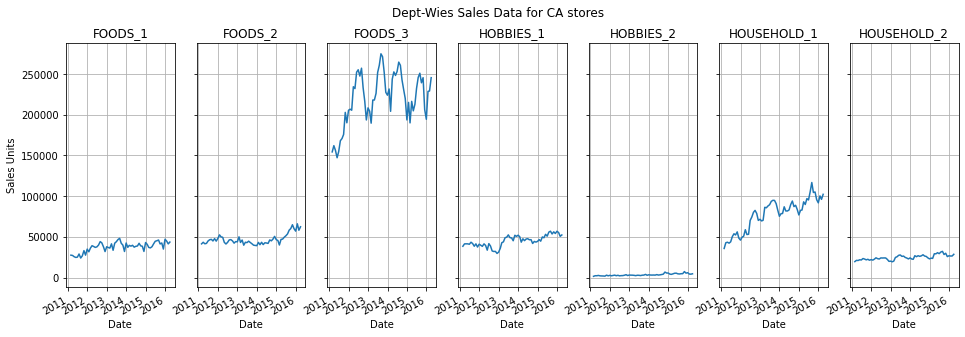

In [10]:
ca_stores_df = df_grouped_statewise.get_group('CA')

departments = np.unique(ca_stores_df['dept_id'].values)

fig, axs = plt.subplots(1, len(departments), figsize=(16, 5), sharey=True)
fig.suptitle('Dept-Wies Sales Data for CA stores')

for i, d in enumerate(departments):
    axs[i].set_title('%s' % d)
    axs[i].set(xlabel='Date')
    if i == 0:
        axs[i].set(ylabel='Sales Units')
    axs[i].grid(True)
    dept_sales_data = ca_stores_df[ca_stores_df['dept_id'] == d]
    aggr_array = []
    for d in date_cols:
        aggr_array.append(dept_sales_data[d].values.sum())
    daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)
    monthly_time_seies_df = daily_time_series_df.resample('1M').sum()
    axs[i].plot(monthly_time_seies_df.index[1:-1], monthly_time_seies_df['Sales'].values[1:-1],
                label='%s' % store_name)
fig.autofmt_xdate()
fig.show()

## Decompose Time Series Data into Trend and Seasonality
Got these excellent explations from the website:
https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting

Time Series Components
A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.

**Systematic**: Components of the time series that have consistency or recurrence and can be described and modeled.
**Non-Systematic**: Components of the time series that cannot be directly modeled.
A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

**Level**: The average value in the series.

**Trend**: The increasing or decreasing value in the series.

**Seasonality**: The repeating short-term cycle in the series.

**Noise**: The random variation in the series.

**Additive Model**
An additive model suggests that the components are added together as follows:

y(t) = Level + Trend + Seasonality + Noise
An additive model is linear where changes over time are consistently made by the same amount.

**Multiplicative Model**
A multiplicative model suggests that the components are multiplied together as follows:

y(t) = Level x Trend x  Seasonality x  Noise

As a first step we can analyse the series assuming it as a Additive data.
Here I am trying with naive decomposition to begin with.

In [11]:
aggr_array = []
for d in date_cols:
    aggr_array.append(sales_train_val[d].values.sum())

daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)


series = daily_time_series_df['Sales']
result = seasonal_decompose(series, model='additive')
result_list = [result.trend, result.seasonal, result.resid, result.observed]

fig = make_subplots(rows=len(result_list), cols=1, subplot_titles=("Trend", "Seasonal", "Residual", "Observed"))

for i, res in enumerate(result_list):
    fig.add_trace(go.Scatter(x=date_range, y=res, showlegend=True, mode='lines'), row=i + 1, col=1)

                  
fig.update_layout(title="Seasonal Decomposition", height=1000, width=1000)
fig.update_xaxes(title_text="Date", row=4, col=1)
fig.update_yaxes(title_text="Value", row=1, col=1)
fig.update_yaxes(title_text="Value", row=2, col=1)
fig.update_yaxes(title_text="Value", row=3, col=1)
fig.update_yaxes(title_text="Value", row=4, col=1)                
fig.show()



## Observations
Clearly we can see the different components at play. At this moment we can not be so sure if this is the exact decomposition we want. But honestly it looks nice to me!
Lets have a closer look at the Sesonal component, before even having a look I would guess its the weekly variations captured in there. But anyways lets have a look!

In [12]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=date_range[:140], y=result_list[1][:140], showlegend=True, mode='lines'))
fig.update_layout(title="Seasonal Component", xaxis_title="Date", yaxis_title="Units/Value", height=500, width=800)
fig.show()

### Observations continued
Okay if we can have an even closer look, its clear that it shows the weekly fluctuations in the sales data where the sales peaks at weekends(Saturday and Sunday).

Moving to the noise component(noise), The dip at year end is captured there rather being in seasonal trend. But its okay we know whats going on right.

It would be a good comparison between the Trend part of of the decomposition and the overall trend for Observed data. It can bring in an idea how effective our decomposition algorithm is here.Lets bring in polynomial regressor do make a trendline

In [13]:
aggr_array = []
for d in date_cols:
    aggr_array.append(sales_train_val[d].values.sum())

daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)

X_values = range(len(daily_time_series_df))
coeffs = np.polyfit(X_values, daily_time_series_df['Sales'].values, 5)
poly_eqn = np.poly1d(coeffs)
y_hat = poly_eqn(X_values)

daily_time_series_df['sales_trend'] = y_hat

# since there are some nan values at the beginning and end lets take those values out.
decomp_trend = result.trend[3:-3]
coeffs = np.polyfit(X_values[3:-3], decomp_trend, 5)
poly_eqn = np.poly1d(coeffs)
y_hat = poly_eqn(X_values)

daily_time_series_df['sales_trend_decomp'] = y_hat

fig = go.Figure()
fig.add_trace(go.Scatter(x=daily_time_series_df.index, y=daily_time_series_df['Sales'].values,
                             showlegend=True, mode='lines'))
fig.add_trace(go.Scatter(x=daily_time_series_df.index, y=daily_time_series_df['sales_trend'].values, mode='lines',
                        showlegend=True, marker=dict(color="black"), name='observed_trend'))
fig.add_trace(go.Scatter(x=daily_time_series_df.index, y=daily_time_series_df['sales_trend_decomp'].values, mode='lines',
                        showlegend=True, marker=dict(color="orange"), name = 'decomposed trend'))
fig.update_layout(
    title="Observed Sales and trend-line", xaxis_title="Date", yaxis_title="Unit Sales", height=500, width=1000)
fig.show()

Its clear from the plots that, the trendline from seasonal decomposition is quite aligned with the observed trendline. Hence the naive decomposition does a very good job in getting here the trend right.
Another thing we can perform is doing a multiplicative decomposition and analyse the results.


To be continued